# Train 2D landmarks detector

In [1]:
import os
import matplotlib
import cv2
import sys
import numpy as np
from matplotlib import pyplot as plt
from datatools import Loader2D, Generator, Aug2D
from traintools import plot_history, get_callbacks, create_dirs
from testtools import plot2D

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # gpu id to use

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Main settings

In [2]:
data_dir = "300W"
project_name = "new"
imsize = (64, 64)
used_lmarks = None

In [ ]:
# Choise only needed landmarks or skip this cell
used_lmarks = []
for i in [8, 30, 36, 39, 42, 45, 48, 54]:
    used_lmarks += list(range(i*2, i*2+2))

## Data loaders initialization and checkup

In [3]:
loader_train = Loader2D(data_dir=os.path.join(data_dir, "train_crop"), 
                        img_size=imsize, 
                        valid_size=0, 
                        augmenter=Aug2D(),
                        used_lmarks=used_lmarks
                       )   
loader_valid = Loader2D(data_dir=os.path.join(data_dir, "test_crop"), 
                        img_size=imsize, 
                        valid_size=1, 
                        augmenter=None,
                        used_lmarks=used_lmarks
                       )  

In [8]:
# Test a generator
n = 0
for x, y in Generator(loader_valid, 8).get_iterator(train=False):
    n += 1
    print(x.shape, y.shape)
    if n >= 3:
        break

(8, 64, 64, 1) (8, 136)
(8, 64, 64, 1) (8, 136)
(8, 64, 64, 1) (8, 136)


img min/max: 21.0 255.0


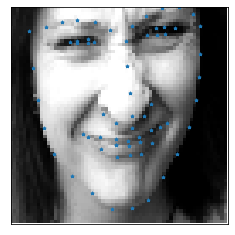

In [9]:
x, y = loader_train.get_item(loader_train.train_set[np.random.randint(10)])
plot2D(x, y.reshape(-1, 2))
print("image min/max:", x.min(), x.max())

## Model initialization

In [10]:
from models import vanilla, fconv2d

model = vanilla((imsize[1], imsize[0], 1))
print(model.summary(100))

Model: "landmarks-vanilla2d"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
data (InputLayer)                            [(None, 64, 64, 1)]                     0              
____________________________________________________________________________________________________
lambda (Lambda)                              (None, 64, 64, 1)                       0              
____________________________________________________________________________________________________
conv_block_01_conv (Conv2D)                  (None, 64, 64, 16)                      416            
____________________________________________________________________________________________________
conv_block_01_act (Activation)               (None, 64, 64, 16)                      0              
______________________________________________________________

In [11]:
from tensorflow.keras.optimizers import Adam
logdir = create_dirs(project_name)

model.compile(loss="mean_absolute_error", optimizer=Adam())

## Start training

In [12]:
gen_train = Generator(loader_train, 4)
gen_valid = Generator(loader_valid, 4)

In [ ]:
history = model.fit_generator(generator=gen_train.get_iterator(train=True),
                              steps_per_epoch=20,
                              epochs=400,
                              initial_epoch=0,
                              validation_data=gen_valid.get_iterator(train=False),
                              validation_steps=2,
                              callbacks=get_callbacks(logdir, 0.002, 350),
                              use_multiprocessing=False
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/400
20/20 [==============================] - ETA: 0s - loss: 0.2447
Epoch 00001: val_loss improved from inf to 0.12367, saving model to ./new\checkpoints\model.h5
20/20 [==============================] - 2s 109ms/step - loss: 0.2447 - val_loss: 0.1237
Epoch 2/400
20/20 [==============================] - ETA: 0s - loss: 0.1033
Epoch 00002: val_loss improved from 0.12367 to 0.08138, saving model to ./new\checkpoints\model.h5
20/20 [==============================] - 2s 93ms/step - loss: 0.1033 - val_loss: 0.0814
Epoch 3/400
20/20 [==============================] - ETA: 0s - loss: 0.0749
Epoch 00003: val_loss did not improve from 0.08138
20/20 [==============================] - 2s 88ms/step - loss: 0.0749 - val_loss: 0.0856
Epoch 4/400
20/20 [==============================] - ETA: 0s - loss: 0.0813
Epoch 00004: val_loss improved from 0.08138 to 0.08067, saving model to ./new\checkpoints\model.h5
20/20 [====

20/20 [==============================] - 2s 95ms/step - loss: 0.0427 - val_loss: 0.0529
Epoch 36/400
 7/20 [=========>....................] - ETA: 0s - loss: 0.0400

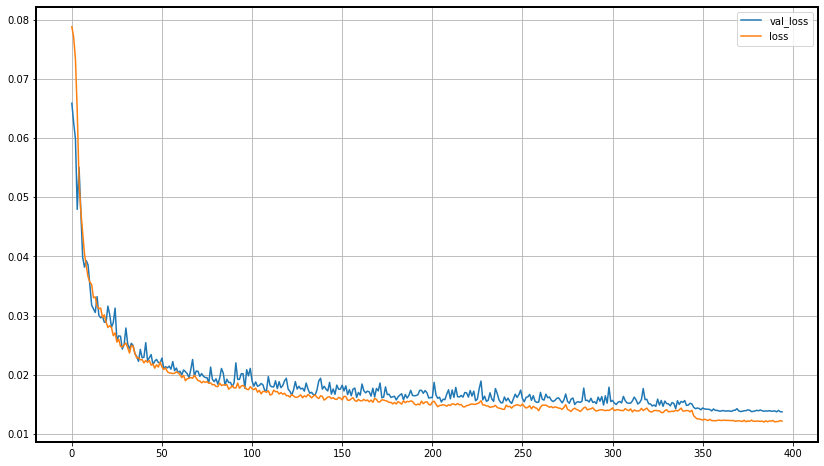

In [28]:
model.save(os.path.join(logdir, "checkpoints", "model_final.h5"))
plot_history(logdir, history)

## Model validation

In [14]:
%%time
# CALC TEST METRICS WITHOUT AUGMENTATION
gen_test = Generator(loader_valid, 7)
model.evaluate(gen_test.get_iterator(train=False), steps=100)

100/100 [==============================] - 2s 23ms/step - loss: 0.0136
CPU times: user 2.82 s, sys: 156 ms, total: 2.98 s
Wall time: 2.48 s


0.013635175302624702

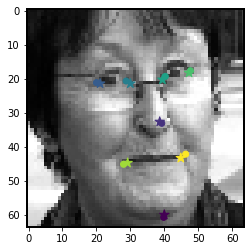

In [15]:
loader_valid.do_augmentation = True
item_id = np.random.randint(100)
x, y = loader_valid.get_item(loader_valid.valid_set[item_id])

lmarks = model.predict(np.expand_dims(x, 0)).flatten()
#print(model.evaluate(np.expand_dims(x, 0), np.expand_dims(y, 0), steps=1, verbose=0))
show_xy(x, y, lmarks)

In [21]:
from testtools import CropTester
def keras_wrapper(img_crop):
    """
    input img_crop: face crop before resize
    output: landmarks as flatten np.array
    """
    net_input = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    net_input = cv2.resize(net_input, model.input_shape[1:-1][::-1])
    net_input = net_input.reshape(1, net_input.shape[0], net_input.shape[1], 1)
    lmarks = model.predict(net_input)
    return lmarks

ct = CropTester(keras_wrapper, num_iterations=5, pad_min_max=(0.0, 0.), crop_type="rand", rseed=1)
#ct.test_image("/media/hdd/public/Datasets/faces/300W/test_crop/ibug/000385.png")
ct.test_image("/media/hdd/public/Datasets/faces/300W/test_crop/helen/000022.png", color=(255, 0, 0))

ct.mean_pixel_std()

>>> Output images are placed in ./croptest_out folder


0.0

## Freeze model

In [17]:
model = fconv2d((imsize[1], imsize[0], 1), 8, train_mode=False)
model.load_weights(os.path.join(logdir, "checkpoints/model_final.h5"), by_name=True)
model.save(os.path.join(logdir, "checkpoints/model_infer.h5"))

In [18]:
import subprocess
import sys
subprocess.Popen([r"/bin/bash"])
process_params = [r"{}".format(sys.executable),
                  r"freeze_graph.py",
                  r"{}".format(os.path.join(logdir, "checkpoints/model_infer.h5"))]
res = subprocess.Popen(process_params)

In [14]:
import sys
sys.executable

'/usr/bin/python3.7'

In [18]:
!nvidia-smi

Thu Apr  7 13:52:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40           Off  | 00000000:02:00.0 Off |                    0 |
| N/A   34C    P0    61W / 250W |  10880MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40           Off  | 00000000:03:00.0 Off |                    0 |
| N/A   35C    P0    60W / 250W |    292MiB / 11448MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [19]:
!/usr/bin/python3.7 freeze_graph.py bn_tuning/checkpoints/model_infer.h5

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Traceback (most recent call last):
  File "freeze_graph.py", line 58, in <module>
    test_input = np.ones((1,) + model.input.shape[1:])
TypeError: can only concatenate tuple (not "TensorShape") to tuple


In [24]:
import tensorflow
from tensorflow import keras

print(tensorflow.__version__)
print(keras.__version__)
print(sys.executable)

2.2.0
2.3.0-tf
/usr/bin/python3.7
